# 2 Recommender Systems 
We will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.
This dataset consists of ratings on a scale of 1 to 5. 
The dataset has n_u = 943 users, and n_m = 1682 movies.


In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

## 2.1 Movie ratings dataset 

In [2]:
data = scipy.io.loadmat('data/ex8_movies.mat')
Y = data['Y'] # a matrix stores the rating from 1 to 5 of shape (1682,943)
R = data['R'] # an binary-valued indicator matrix of shape (1682,943)
              # where R[i,j] = 1 if user j gave a rating to movie i, and R[i,j] = 0 otherwise.
    
n_m, n_u = Y.shape

Average rating for movie 1 (Toy Story): 3.88 / 5


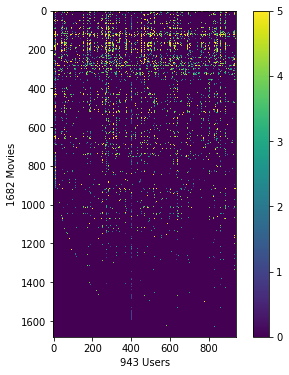

In [3]:
avg_rating = np.mean(Y[0, R[0, :]==1])
print('Average rating for movie 1 (Toy Story): {:.2f} / 5'.format(avg_rating))

# Visualize the ratings matrix
plt.figure(figsize=(6,6))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('{} Movies'.format(n_m))
plt.xlabel('{} Users'.format(n_u))
plt.show()

## 2.2 Collaborative filtering learning algorithm 

The collaborative filtering algorithm in the setting of movie recommendations 
considers a set of n-dimensional parameter vectors 
x[0] , ..., x[n_m-1] and θ[0],...,θ[n_u-1], 
where the model predicts the rating for movie i by user j as Y[i, j] = (θ[ j ]).T.dot(x[i]). 

We wish to learn the parameter vectors x(1),...,x(n_m), θ(1),...,θ(n_u) that produce the best fit 
(minimizes the squared error).



In [4]:
# Load pre-trained weights
data = scipy.io.loadmat('data/ex8_movieParams.mat')
X = data['X']
Theta = data['Theta']

# Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3
X = X[:num_movies, :num_features]        # shape:(5,3)
Theta = Theta[:num_users, :num_features] # shape:(4,3)
Y = Y[:num_movies, :num_users]           # shape:(5,4) 
R = R[:num_movies, :num_users]           # shape:(5,4)

In [5]:
def flattenParams(param1, param2):
    p1 = param1.flatten()
    p2 = param2.flatten()
    params = np.append(p1, p2)
    return params

def reshapeParams(params, num_users, num_movies, num_features):
    X = params[:int(num_movies*num_features)].reshape((num_movies, num_features))
    Theta = params[int(num_movies*num_features):].reshape((num_users, num_features))
    return X, Theta

### 2.2.1 Collaborative filtering cost function & 2.2.3 Regularized cost function 

In [6]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, _lambda):
    """
    returns the cost for the collaborative filtering problem
    """
    X, Theta = reshapeParams(params, num_users, num_movies, num_features)
    J = np.sum(np.sum((X.dot(Theta.T)*R - Y*R)**2)/2 + (_lambda/2)*np.sum(Theta**2) + (_lambda/2)*np.sum(X**2))
    
    return J

In [7]:
params = flattenParams(X, Theta)
J1 = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0.)
J2 = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)

print('Cost at loaded parameters (lambda = 0.): {:.2f} \n(this value should be about 22.22)'.format(J1))
print('Cost at loaded parameters (lambda = 1.5): {:.2f} \n(this value should be about 31.34)'.format(J2))

Cost at loaded parameters (lambda = 0.): 22.22 
(this value should be about 22.22)
Cost at loaded parameters (lambda = 1.5): 31.34 
(this value should be about 31.34)


### 2.2.2 Collaborative filtering gradient & 2.2.4 Regularized gradient 

In [8]:
def cofiGrad(params, Y, R, num_users, num_movies, num_features, _lambda):
    """
    returns the gradient for the collaborative filtering problem
    """
    X, Theta = reshapeParams(params, num_users, num_movies, num_features)
    X_grad = (X.dot(Theta.T)*R - Y*R).dot(Theta) + _lambda*X
    Theta_grad = (X.dot(Theta.T)*R - Y*R).T.dot(X) + _lambda*Theta
    grad = flattenParams(X_grad, Theta_grad)
    return grad

## 2.3 Learning movie recommendations

In [9]:
import pandas as pd
df = pd.read_csv('data/movie_ids.txt', names=['movies'], encoding='latin-1') # UTF-8 fails
df.head()

,movies
0,1 Toy Story (1995)
1,2 GoldenEye (1995)
2,3 Four Rooms (1995)
3,4 Get Shorty (1995)
4,5 Copycat (1995)


In [10]:
movies = []
for m in df['movies']:
    movies.append(' '.join(m.split(' ')[1:]))

print('There are {} movies in total.'.format(len(movies)))
movies[:5]

There are 1682 movies in total.


['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)']

In [11]:
# some movies has been rated in homework
ratings = np.zeros((1682,1))
ratings[0]   = 4
ratings[97]  = 2
ratings[6]   = 3
ratings[11]  = 5
ratings[53]  = 4
ratings[63]  = 5
ratings[65]  = 3
ratings[68]  = 5
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [12]:
data = scipy.io.loadmat('data/ex8_movies.mat')
Y = data['Y'] # a matrix stores the rating from 1 to 5 of shape (1682,943)
R = data['R'] # an binary-valued indicator matrix of shape (1682,943)
              # where R[i,j] = 1 if user j gave a rating to movie i, and R[i,j] = 0 otherwise.

# Add our own ratings to the data matrix
Y = np.append(ratings, Y, axis=1)
R = np.append(np.c_[ratings!=0], R, axis=1)

In [13]:
def normalizeRatings(Y, R):
    """
    If we skip this step, a user who has not rated any movies will get predicted score of 0 for every movie.
    It is because the regularization term in costfunction encourags us to set parameters close to 0 
    And it makes sense if we let predicted score be the average score of that movie.
    """
    Ymean = np.c_[np.sum(Y, axis=1)/np.sum(R, axis=1)]
    Ynorm = Y - Ymean
    return Ynorm, Ymean

Ynorm, Ymean = normalizeRatings(Y, R)

In [14]:
# Useful Values
num_movies, num_users = Ynorm.shape
num_features = 10
_lambda = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = flattenParams(X, Theta)

In [15]:
# training collaborative filtering
from scipy import optimize

def optimizer(initial_parameters, Ynorm, R, num_users, num_movies, num_features, _lambda):  
    res = optimize.fmin_cg(cofiCostFunc, x0=initial_parameters, fprime=cofiGrad, 
                           args=(Ynorm, R, num_users, num_movies, num_features, _lambda),
                           maxiter=100)
    return res

params = optimizer(initial_parameters, Ynorm, R, num_users, num_movies, num_features, _lambda)

         Current function value: 38956.536290
         Iterations: 100
         Function evaluations: 147
         Gradient evaluations: 147


### 2.3.1 Recommendations

In [16]:
# unfold the params and get the prediction matrix
X, Theta = reshapeParams(params, num_users, num_movies, num_features)
prediction_matrix = X.dot(Theta.T)

# because we implemented mean normalization, we have to add the average back
predictions = prediction_matrix[:,0] + Ymean.flatten()

# find the index and sort them in the descending order
pred_idxs = np.argsort(predictions)[::-1]

In [17]:
print('Top recommendations for you:')
for i in range(10):
    print('Predicting rating {:0.1f} for movie {}.'.format(predictions[pred_idxs[i]],movies[pred_idxs[i]]))
    
print('\nOriginal ratings provided:')
for i in range(len(ratings)):
    if ratings[i] > 0:
        print('Rated {} for movie {}.'.format(int(ratings[i]), movies[i]))

Top recommendations for you:
Predicting rating 5.0 for movie Aiqing wansui (1994).
Predicting rating 5.0 for movie Someone Else's America (1995).
Predicting rating 5.0 for movie Santa with Muscles (1996).
Predicting rating 5.0 for movie Prefontaine (1997).
Predicting rating 5.0 for movie Star Kid (1997).
Predicting rating 5.0 for movie They Made Me a Criminal (1939).
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicting rating 5.0 for movie Saint of Fort Washington.
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicting rating 5.0 for movie Great Day in Harlem.

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects.
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption.
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs.
Rated 4 for movie